# AMLS final project

This notebook contains the work for the ELEC0134 Applied Machine Learning Systems class at UCL. The solution is implemented in Keras.

## Using Drive with Colab, typical imports

In [1]:
# Set up Google Drive for use with Colaboratory
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

# Magic calls TensorFlow 2.0 when importing
%tensorflow_version 2.x
import tensorflow as tf

# This tests whether a GPU is running
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

# Import Keras
from tensorflow import keras

# Check version of TensorFlow and Keras
print(tf.__version__)
print(keras.__version__)

TensorFlow 2.x selected.
Found GPU at: /device:GPU:0
2.1.0-rc1
2.2.4-tf


## Changing directory, sanity checks

In [0]:
root_dir = "/content/drive/My Drive/"
change_dir = root_dir + "dataset_AMLS_19-20/celeba"

os.chdir(change_dir)

In [4]:
# Check current directory
!pwd

/content/drive/My Drive/dataset_AMLS_19-20/celeba


In [5]:
# List contents of directory
!ls

img  labels.csv


## Creating data input pipeline

In [0]:
# Import data as dataframe, drop unnecessary column
df = pd.read_csv("labels.csv", sep="\t", dtype=str)

# Create separate dataframes for gender and smiling
gender = df.copy()
smiling = df.copy()

gender.drop(gender.columns[0], axis=1, inplace=True)
gender.drop(gender.columns[2], axis=1, inplace=True)

smiling.drop(smiling.columns[0], axis=1, inplace=True)
smiling.drop(smiling.columns[1], axis=1, inplace=True)

In [7]:
# Inspect data
df.head()

,Unnamed: 0,img_name,gender,smiling
0,0,0.jpg,-1,1
1,1,1.jpg,-1,1
2,2,2.jpg,1,-1
3,3,3.jpg,-1,-1
4,4,4.jpg,-1,-1


In [8]:
gender.head()

,img_name,gender
0,0.jpg,-1
1,1.jpg,-1
2,2.jpg,1
3,3.jpg,-1
4,4.jpg,-1


In [9]:
len(gender)

5000

In [10]:
smiling.head()

,img_name,smiling
0,0.jpg,1
1,1.jpg,1
2,2.jpg,-1
3,3.jpg,-1
4,4.jpg,-1


In [0]:
# Now, we create training and test sets for the gender and smiling datasets

from sklearn.model_selection import train_test_split

gender_train, gender_test = train_test_split(
    gender, 
    test_size=0.2,
    random_state=42
    )

smiling_train, smiling_test = train_test_split(
    smiling, 
    test_size=0.2, 
    random_state=42
    )

In [12]:
gender_train.head()

,img_name,gender
4227,4227.jpg,-1
4676,4676.jpg,1
800,800.jpg,1
3671,3671.jpg,-1
4193,4193.jpg,-1


In [13]:
len(gender_train)

4000

In [14]:
gender_test.head()

,img_name,gender
1501,1501.jpg,-1
2586,2586.jpg,-1
2653,2653.jpg,-1
1055,1055.jpg,-1
705,705.jpg,1


In [15]:
smiling_train.head()

,img_name,smiling
4227,4227.jpg,1
4676,4676.jpg,1
800,800.jpg,-1
3671,3671.jpg,1
4193,4193.jpg,-1


In [0]:
# We check the average dimensions of the images in the dataset

# Code from
# https://towardsdatascience.com/image-classification-python-keras-tutorial-kaggle-challenge-45a6332a58b8

from PIL import Image

def get_size_statistics(DIR, number_of_files):
  heights = []
  widths = []
  counter = 1
  for img in os.listdir(DIR):
    path = os.path.join(DIR, img)
    print("Opening " + path + ": " + str(counter) + "/" + str(number_of_files))
    data = np.array(Image.open(path)) # PIL Image library
    heights.append(data.shape[0])
    widths.append(data.shape[1])
    counter += 1
  avg_height = sum(heights) / len(heights)
  avg_width = sum(widths) / len(widths)
  print('\n')
  print("Average Height: " + str(avg_height))
  print("Max Height: " + str(max(heights)))
  print("Min Height: " + str(min(heights)))
  print('\n')
  print("Average Width: " + str(avg_width))
  print("Max Width: " + str(max(widths)))
  print("Min Width: " + str(min(widths)))

get_size_statistics("img/", len(df))

In [16]:
# We now create two ImageDataGenerator objects for the gender dataset:
# one for training, the other for validation
from keras.preprocessing.image import ImageDataGenerator

# https://forums.fast.ai/t/split-data-using-fit-generator/4380/4
# for validation split

# We rescale to ensure RGB values fall between 0 and 1
# We set aside 20% of the training set for validation
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# We generate an image-label pair for the training set as follows
gender_train_gen = datagen.flow_from_dataframe(
    dataframe=gender_train, 
    directory="img/",
    x_col="img_name",
    y_col="gender",
    class_mode="sparse",
    target_size=(218,178),
    batch_size=32,
    subset="training"
    )

# We generate an image-label pair for the validation set as follows
gender_val_gen = datagen.flow_from_dataframe(
    dataframe=gender_train,
    directory="img/",
    x_col="img_name",
    y_col="gender",
    class_mode="sparse",
    target_size=(218,178),
    batch_size=32,
    subset="validation"
    )

Using TensorFlow backend.


Found 3200 validated image filenames belonging to 2 classes.
Found 800 validated image filenames belonging to 2 classes.


In [17]:
# We generate an image-label pair for the gender test set as follows
gender_test_gen = datagen.flow_from_dataframe(
    dataframe=gender_test,
    directory="img/",
    x_col="img_name",
    y_col="gender",
    class_mode="sparse",
    target_size=(218,178),
    batch_size=1000
    )

Found 1000 validated image filenames belonging to 2 classes.


In [0]:
# Convert gender test generator into numpy arrays
# https://stackoverflow.com/questions/49547042/how-to-get-the-created-numpy-arrays-from-keras-generator
itr = gender_test_gen
gender_X_test, gender_y_test = itr.next()

In [19]:
# Create two ImageDataGenerator objects for the smiling dataset in a similar way

# https://forums.fast.ai/t/split-data-using-fit-generator/4380/4
# for validation split

# We rescale to ensure RGB values fall between 0 and 1
# We set aside 20% of the training set for validation
datagen = ImageDataGenerator(rescale=1./255,
                             validation_split=0.2)

# We generate an image-label pair for the training set as follows
smiling_train_gen = datagen.flow_from_dataframe(
    dataframe=smiling_train,
    directory="img/",
    x_col="img_name",
    y_col="smiling",
    class_mode="sparse",
    target_size=(218,178),
    batch_size=32,
    subset="training"
    )

# We generate an image-label pair for the validation set as follows
smiling_val_gen = datagen.flow_from_dataframe(
    dataframe=smiling_train,
    directory="img/",
    x_col="img_name",
    y_col="smiling",
    class_mode="sparse",
    target_size=(218,178),
    batch_size=32,
    subset="validation"
    )

Found 3200 validated image filenames belonging to 2 classes.
Found 800 validated image filenames belonging to 2 classes.


## Building and training the models



### Multi-layer Perceptron (MLP)

In [0]:
# Creating a classification MLP with two hidden layers
# We are using the Sequential API which creates a stack of layers
# in which the input flows through one after the other

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Instantiate Sequential API
mlp_model = keras.models.Sequential()

# This flattens the 218x178x3 input into a 1D tensor
mlp_model.add(keras.layers.Flatten(input_shape=(218,178,3)))

# This adds a fully connected layer with 300 neurons using the ReLU
# activation function
mlp_model.add(keras.layers.Dense(300, activation="relu"))

# This adds a fully connected layer with 100 neurons using the ReLU
# activation function
mlp_model.add(keras.layers.Dense(100, activation="relu"))

# This creates the output layer.
mlp_model.add(keras.layers.Dense(2, activation="softmax"))

In [0]:
# We now compile the MLP model to specify the loss function
# and the optimizer to use (SGD)
mlp_model.compile(loss="sparse_categorical_crossentropy", # b/c of exclusive, sparse outputs
                  optimizer="sgd", # We use SGD to optimise the ANN
                  metrics=["accuracy"] # Used for classifiers
                  ) 

In [21]:
# Training and evaluating the MLP model on the gender dataset
mlp_gender_history = mlp_model.fit(
    gender_train_gen,
    steps_per_epoch=gender_train_gen.samples // 32,
    validation_data=gender_val_gen,
    validation_steps=gender_val_gen.samples // 32,
    epochs=30
    )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100 steps, validate for 25 steps
Epoch 1/30
100/100 [==============================] - 1249s 12s/step - loss: 0.8182 - accuracy: 0.5525 - val_loss: 0.6377 - val_accuracy: 0.6513
Epoch 2/30
100/100 [==============================] - 9s 92ms/step - loss: 0.6231 - accuracy: 0.6581 - val_loss: 0.6259 - val_accuracy: 0.6175
Epoch 3/30
100/100 [==============================] - 9s 94ms/step - loss: 0.5586 - accuracy: 0.7128 - val_loss: 0.6365 - val_accuracy: 0.6625
Epoch 4/30
100/100 [==============================] - 9s 93ms/step - loss: 0.5312 - accuracy: 0.7369 - val_loss: 0.5310 - val_accuracy: 0.7412
Epoch 5/30
100/100 [==============================] - 9s 92ms/step - loss: 0.5098 - accuracy: 0.7513 - val_loss: 0.5601 - val_accuracy: 0.7038
Epoch 6/30
100/100 [==============================] - 9s 92ms/step - loss: 0.4606 - accuracy: 0.7875 - val_loss: 0.4595 - val_accuracy: 0.7937
Epoch 7/30
100/100 [===========================

In [176]:
# Get indices of wrongfully misclassified test set
# https://stackoverflow.com/questions/39300880/how-to-find-wrong-prediction-cases-in-test-set-cnns-using-keras
incorrects = np.asarray(np.nonzero(mlp_model.predict_classes(gender_X_test).reshape((-1,)) != gender_y_test))
incorrects = incorrects.T.flatten()
incorrects

array([  5,   6,   9,  11,  13,  14,  15,  19,  29,  31,  36,  43,  50,
        62,  63,  84,  87,  95, 111, 115, 122, 124, 140, 150, 171, 178,
       179, 184, 194, 213, 219, 231, 234, 238, 246, 254, 262, 270, 294,
       296, 298, 309, 311, 316, 324, 328, 335, 355, 356, 363, 370, 371,
       386, 388, 396, 399, 400, 401, 402, 414, 417, 418, 422, 423, 427,
       432, 452, 457, 458, 461, 464, 465, 489, 495, 520, 533, 534, 536,
       554, 560, 581, 590, 592, 616, 618, 628, 649, 664, 668, 671, 681,
       687, 703, 707, 709, 727, 740, 746, 749, 753, 758, 761, 764, 771,
       797, 803, 808, 813, 817, 819, 828, 846, 847, 854, 858, 868, 871,
       882, 884, 887, 891, 898, 902, 911, 920, 922, 925, 929, 939, 944,
       953, 955, 956, 958, 967, 974, 984, 993])

In [177]:
# This returns an array which contains the predictions for the misclassified images
incorrect_preds = []

for incorrect in np.nditer(incorrects):
    incorrect_pred = mlp_model.predict_classes(gender_X_test[incorrect:incorrect+1])
    incorrect_preds.append(incorrect_pred)

incorrect_preds = np.asarray(incorrect_preds)
incorrect_preds = incorrect_preds.T.flatten()
incorrect_preds

array([1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 1])

In [178]:
incorrect_preds.shape

(138,)

In [179]:
# This returns an array which contains the actual labels for the misclassified images
actual_labels = []

for incorrect in np.nditer(incorrects):
    actual_label = gender_y_test[incorrect]
    actual_labels.append(actual_label)

actual_labels = np.asarray(actual_labels)
actual_labels = actual_labels.T.flatten()
actual_labels

array([0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0.], dtype=float32)

In [180]:
# This returns an array which contains the individual losses for the misclassified images
incorrect_losses = []

for incorrect in np.nditer(incorrects):
    loss = mlp_model.evaluate(gender_X_test[incorrect:incorrect+1], gender_y_test[incorrect:incorrect+1])
    incorrect_losses.append(loss[0])

incorrect_losses = np.asarray(incorrect_losses)

1/1 [==============================] - 0s 4ms/sample - loss: 0.8234 - accuracy: 0.0000e+00


In [181]:
incorrect_losses

array([4.71537399, 4.2856226 , 1.10329056, 2.37403488, 1.30766356,
       0.71452665, 1.36276841, 1.00239682, 6.69332981, 4.85751438,
       1.28368425, 3.28271246, 4.72921228, 2.04277492, 5.03650379,
       1.52255976, 2.13675666, 2.70908737, 1.7128191 , 1.03794098,
       4.37210035, 1.72965872, 2.27850771, 0.74728411, 3.26538873,
       1.83514643, 2.39425755, 0.82832527, 1.05677032, 0.74965221,
       2.81758595, 1.37949753, 2.70742607, 1.59459138, 1.19231319,
       4.03536224, 1.33946669, 2.58936048, 0.78194106, 0.71200007,
       2.39580655, 1.61141169, 0.91047865, 1.78337264, 1.2014426 ,
       1.08529878, 1.21545422, 0.71222889, 1.07027376, 1.35697067,
       1.42442513, 1.18591273, 3.66718936, 5.08338642, 2.81281805,
       1.94588947, 2.59852886, 0.85418081, 1.22826481, 4.4333539 ,
       1.34848869, 3.64814329, 0.89650702, 1.91944766, 3.06452966,
       2.25896215, 2.1748333 , 5.07671309, 1.06132865, 0.93669999,
       3.86602116, 1.55945098, 4.48964167, 0.93109012, 4.59047

In [0]:
# This returns an array which contains the probabilities of the actual label for the misclassified images
probs_correct_label = []

for incorrect in np.nditer(incorrects):
    prob_correct_label = mlp_model.predict(gender_X_test[incorrect:incorrect+1])
    probs_correct_label.append(prob_correct_label[0,int(gender_y_test[incorrect])])

probs_correct_label = np.asarray(probs_correct_label)

In [183]:
probs_correct_label

array([0.00895652, 0.01376505, 0.33177754, 0.0931043 , 0.27045122,
       0.4894237 , 0.2559512 , 0.36699876, 0.00123915, 0.00776977,
       0.27701482, 0.03752633, 0.00883342, 0.12966838, 0.00649642,
       0.21815273, 0.11803707, 0.06659756, 0.1803566 , 0.3541832 ,
       0.0126247 , 0.17734493, 0.10243694, 0.47365117, 0.03818209,
       0.15959013, 0.09124041, 0.43678018, 0.34757656, 0.47253087,
       0.05975001, 0.25170502, 0.06670828, 0.20299147, 0.30351835,
       0.01767928, 0.26198536, 0.07506803, 0.4575171 , 0.49066186,
       0.09109917, 0.19960563, 0.4023316 , 0.16807035, 0.30076   ,
       0.33780083, 0.29657528, 0.49054962, 0.34291464, 0.25743946,
       0.24064678, 0.30546725, 0.02554817, 0.00619888, 0.06003558,
       0.14286008, 0.07438292, 0.4256317 , 0.2928002 , 0.0118746 ,
       0.25963232, 0.02603943, 0.40799227, 0.14668794, 0.04667579,
       0.10445885, 0.11362708, 0.00624039, 0.34599578, 0.39191902,
       0.02094153, 0.21025148, 0.01122467, 0.39412385, 0.01014

In [184]:
type(incorrects)

numpy.ndarray

In [185]:
type(incorrect_losses)

numpy.ndarray

In [186]:
type(probs_correct_label)

numpy.ndarray

In [187]:
type(incorrect_preds)

numpy.ndarray

In [188]:
type(actual_labels)

numpy.ndarray

In [165]:
incorrects.shape

(138,)

In [189]:
incorrect_preds.shape

(138,)

In [190]:
actual_labels.shape

(138,)

In [166]:
incorrect_losses.shape

(138,)

In [79]:
probs_correct_label.shape

(138,)

In [195]:
print(incorrects.dtype)
print(incorrect_preds.dtype)
print(actual_labels.dtype)
print(incorrect_losses.dtype)
print(probs_correct_label.dtype)

int64
int64
float32
float64
float32


In [0]:
incorrects = incorrects.astype(float)
incorrect_preds = incorrect_preds.astype(float)
actual_labels = actual_labels.astype(float)
incorrect_losses = incorrect_losses.astype(float)
probs_correct_label = probs_correct_label.astype(float)

In [197]:
print(incorrects.dtype)
print(incorrect_preds.dtype)
print(actual_labels.dtype)
print(incorrect_losses.dtype)
print(probs_correct_label.dtype)

float64
float64
float64
float64
float64


In [200]:
# This joins together the indices of incorrectly misclassified images, their losses and
# actual label probabilities into a numpy array. It is then sorted in descending order
loss_pred_data = np.column_stack((incorrects, incorrect_preds, actual_labels, incorrect_losses, probs_correct_label))
loss_pred_data = loss_pred_data[np.argsort(loss_pred_data[:,3])[::-1]]
loss_pred_data

array([[2.90000000e+01, 1.00000000e+00, 0.00000000e+00, 6.69332981e+00,
        1.23914937e-03],
       [8.13000000e+02, 1.00000000e+00, 0.00000000e+00, 5.90996552e+00,
        2.71228049e-03],
       [3.88000000e+02, 1.00000000e+00, 0.00000000e+00, 5.08338642e+00,
        6.19887980e-03],
       [4.57000000e+02, 1.00000000e+00, 0.00000000e+00, 5.07671309e+00,
        6.24038652e-03],
       [6.30000000e+01, 1.00000000e+00, 0.00000000e+00, 5.03650379e+00,
        6.49642013e-03],
       [3.10000000e+01, 1.00000000e+00, 0.00000000e+00, 4.85751438e+00,
        7.76977232e-03],
       [5.00000000e+01, 1.00000000e+00, 0.00000000e+00, 4.72921228e+00,
        8.83342419e-03],
       [5.00000000e+00, 1.00000000e+00, 0.00000000e+00, 4.71537399e+00,
        8.95651709e-03],
       [6.16000000e+02, 1.00000000e+00, 0.00000000e+00, 4.62263680e+00,
        9.82684921e-03],
       [7.27000000e+02, 1.00000000e+00, 0.00000000e+00, 4.60864878e+00,
        9.96527169e-03],
       [5.20000000e+02, 1.0000

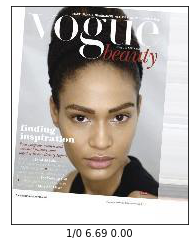

In [228]:
def plot_image(i, loss_pred_data, img_data):
  plt.imshow(img_data[int(loss_pred_data[i,0])])
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.xlabel("{}/{} {:0.2f} {:0.2f}".format(int(loss_pred_data[i,1]),
                                            int(loss_pred_data[i,2]),
                                            loss_pred_data[i,3],
                                            loss_pred_data[i,4]))
  
plot_image(0, loss_pred_data, gender_X_test)

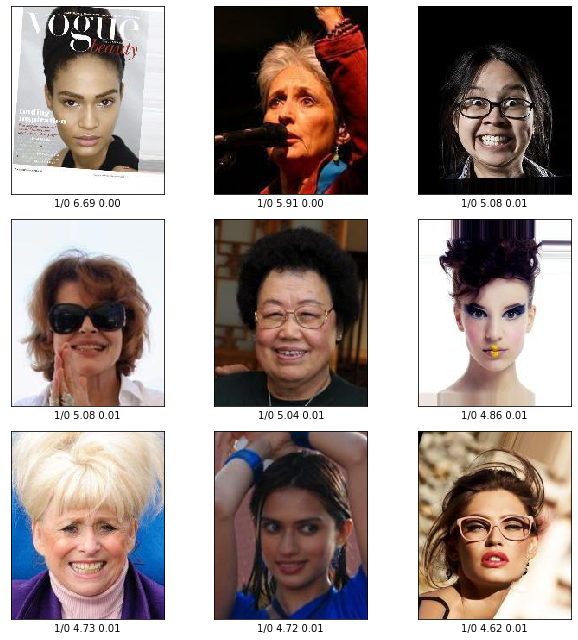

In [242]:
# Get indices of wrongfully misclassified test set
# https://stackoverflow.com/questions/39300880/how-to-find-wrong-prediction-cases-in-test-set-cnns-using-keras
def get_wrong_indices(X_test, y_test):
    incorrects = np.asarray(np.nonzero(mlp_model.predict_classes(X_test).reshape((-1,)) != y_test))
    incorrects = incorrects.T.flatten()
    incorrects = incorrects.astype(float)
    return incorrects

# This returns an array which contains the predictions for the misclassified images
def get_incorrect_preds(X_test, y_test):
    incorrect_preds = []

    for incorrect in np.nditer(incorrects):
        incorrect_pred = mlp_model.predict_classes(X_test[incorrect:incorrect+1])
        incorrect_preds.append(incorrect_pred)

    incorrect_preds = np.asarray(incorrect_preds)
    incorrect_preds = incorrect_preds.T.flatten()
    incorrect_preds = incorrect_preds.astype(float)
    return incorrect_preds

# This returns an array which contains the actual labels for the misclassified images
def get_actual_labels(X_test, y_test):
    actual_labels = []

    for incorrect in np.nditer(incorrects):
        actual_label = y_test[incorrect]
        actual_labels.append(actual_label)

    actual_labels = np.asarray(actual_labels)
    actual_labels = actual_labels.T.flatten()
    actual_labels = actual_labels.astype(float)
    return actual_labels

# This returns an array which contains the individual losses for the misclassified images
def get_incorrect_losses(X_test, y_test):
    incorrect_losses = [] 

    for incorrect in np.nditer(incorrects):
        loss = mlp_model.evaluate(X_test[incorrect:incorrect+1], y_test[incorrect:incorrect+1])
        incorrect_losses.append(loss[0])

    incorrect_losses = np.asarray(incorrect_losses)
    incorrect_losses = incorrect_losses.astype(float)
    return incorrect_losses

def get_probs_correct_label(X_test, y_test):
# This returns an array which contains the probabilities of the actual label
# for the misclassified images
    probs_correct_label = []

    for incorrect in np.nditer(incorrects):
        prob_correct_label = mlp_model.predict(gender_X_test[incorrect:incorrect+1])
        probs_correct_label.append(prob_correct_label[0,int(gender_y_test[incorrect])])

    probs_correct_label = np.asarray(probs_correct_label)
    probs_correct_label = probs_correct_label.astype(float)
    return probs_correct_label = get_probs_correct_label(X_test, y_test)

def create_loss_pred_data(X_test, y_test):
    incorrects = get_wrong_indices(X_test, y_test)
    incorrect_preds = get_incorrect_preds(X_test, y_test)
    actual_labels = get_actual_labels(X_test, y_test)
    incorrect_losses = get_incorrect_losses(X_test, y_test)
    probs_correct_label = get_probs_correct_label(X_test, y_test)

    # This joins together the indices of incorrectly misclassified images, their losses and
    # actual label probabilities into a numpy array. It is then sorted in descending order
    loss_pred_data = np.column_stack((incorrects, 
                                      incorrect_preds, 
                                      actual_labels, 
                                      incorrect_losses, 
                                      probs_correct_label))
    loss_pred_data = loss_pred_data[np.argsort(loss_pred_data[:,3])[::-1]]
    return loss_pred_data

# This plots a single misclassified image alongside its predicted label,
# its actual label, the error rate for the image and the probability given
# to the actual label
def plot_image(i, loss_pred_data, img_data):
    plt.imshow(img_data[int(loss_pred_data[i,0])])
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel("{}/{} {:0.2f} {:0.2f}".format(int(loss_pred_data[i,1]),
                                              int(loss_pred_data[i,2]),
                                              loss_pred_data[i,3],
                                              loss_pred_data[i,4]))

# This plots the images which have been the most misclassified when running the
# model on the test set. Inspired by the plot_top_losses function in the fastai
# library
def plot_top_losses(num_rows, num_cols, loss_pred_data, img_data):
    num_images = num_rows*num_cols
    plt.figure(figsize=(2*num_cols, 2*num_rows))
    for i in range(num_images):
        plt.subplot(num_rows, num_cols, i+1)
        plot_image(i, loss_pred_data, img_data)
    plt.tight_layout()
    return plt.show()

plot_top_losses(3,3,loss_pred_data,gender_X_test)

In [0]:
 # Training and evaluating the MLP model on the smiling dataset
mlp_smiling_history = mlp_model.fit(
    smiling_train_gen,
    steps_per_epoch=smiling_train_gen.samples // 32,
    validation_data=smiling_val_gen,
    validation_steps=smiling_val_gen.samples // 32,
    epochs=30
    )

### Convolutional Neural Network (CNN)

In [0]:
# We create a simple CNN architecture for image classification
# Architecture from:
# https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/classification.ipynb#scrollTo=L1WtoaOHVrVh

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

cnn_model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(218,178,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
    ])

In [0]:
# We now compile the CNN model to specify the loss function
# and the optimizer to use (Adam)
cnn_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
    )

In [0]:
# Training and evaluating the CNN model on the gender dataset
cnn_gender_history = cnn_model.fit(
    gender_train_gen,
    steps_per_epoch=gender_train_gen.samples // 32,
    validation_data=gender_val_gen,
    validation_steps=gender_val_gen.samples // 32,
    epochs=30
    )

In [0]:
# Training and evaluating the CNN model on the smiling dataset
cnn_smiling_history = cnn_model.fit(
    smiling_train_gen,
    steps_per_epoch=smiling_train_gen.samples // 32,
    validation_data=smiling_validation_gen,
    validation_steps=smiling_validation_gen.samples // 32,
    epochs=30
    )

## Next Steps

* Figure out the principles for building a good MLP and CNN and  architecture for image classification
* Read chapter on training deep neural nets
* Rewatch fast.ai lecture 1 on finetuning
* Learn how to implement a model interpreter (similar to that of fast.ai)
* Find out how to implement more advanced CNN architectures for image classification
* Do literature review
* Write the code in a format that works for submission